In [1]:
%pip install ipywidgets matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\lucca\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, Layout
from scipy.stats import norm

In [3]:
# Definition of Black-Scholes function

def black_scholes(S, X, T, option_type: 'str', r = 0, sigma=0):
    '''
    Arguments:
    S           -- current spot price of the underlying security
    X           -- option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- risk-free interest rate 
    sigma       -- returns volatility of the underlying security
    option_type -- the option type, either 'call' or 'put'
    
    Returns: option value [float]
    '''

    # Auxiliary function for d_one & d_two risk-adjusted probability
    d1_fn = lambda S, X, T, r, sigma: (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2_fn = lambda d1, T, sigma: d1 - sigma * np.sqrt(T)

    d_one = d1_fn(S, X, T, r, sigma)
    d_two = d2_fn(d_one, T, sigma)

    if option_type == 'c': 
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'p': 
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type must be either 'call' or 'put'.")

In [4]:
def plot_black_scholes(Spot, Strike, Time, Type, IR, Vol, X_Axis):
    # Define ranges for the parameters
    param_ranges = {
        'Volatility': np.arange(0.05, 1.0, 0.05),
        'Time to Maturity': np.linspace(0.1, 2.0, 20),
        'Spot Price': np.linspace(50, 300, 20),
        'Strike Price': np.linspace(50, 300, 20),
        'Interest Rate': np.linspace(0.0, 0.1, 20)
    }
    
    # Select the x-axis data based on the X_Axis choice
    x_data = param_ranges[X_Axis]
    
    # Calculate option prices for each value on the x-axis
    prices = [black_scholes(
                Spot if X_Axis != 'Spot Price' else x,
                Strike if X_Axis != 'Strike Price' else x,
                Time if X_Axis != 'Time to Maturity' else x,
                Type, 
                IR if X_Axis != 'Interest Rate' else x,
                Vol if X_Axis != 'Volatility' else x
              ) 
              for x in x_data]
    
    # Clear the previous plot and create a new one
    plt.figure(figsize=(10, 6))

    # Plot using seaborn
    sns.lineplot(x=x_data, y=prices)
    plt.xlabel(X_Axis)
    plt.ylabel('Option Price'), plt.ylim(0,300)
    plt.title(f'Black-Scholes Option Pricing with {X_Axis} as X-Axis')
    plt.grid(True)
    plt.show()

widget_layout = Layout(width='300px', height='30px')


interact(plot_black_scholes,
         Spot=IntSlider(min=50, max=300, step=10, value=200, description='Spot Price', layout=widget_layout),
         Strike=IntSlider(min=50, max=300, step=10, value=120, description='Strike Price', layout=widget_layout),
         Time=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.5, description='Time to Maturity', layout=widget_layout),
         Type=Dropdown(options=[('Call','c'),('Put','p')], value='c', description='Option Type', layout=widget_layout),
         IR=FloatSlider(min=0.0, max=0.1, step=0.01, value=0.02, description='Interest Rate', layout=widget_layout),
         Vol=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.5, description='Volatility', layout=widget_layout),
         X_Axis=Dropdown(options=['Volatility', 'Time to Maturity', 'Spot Price', 'Strike Price', 'Interest Rate'], 
                         value='Volatility', description='X-Axis', layout=widget_layout)
)

interactive(children=(IntSlider(value=200, description='Spot Price', layout=Layout(height='30px', width='300px…

<function __main__.plot_black_scholes(Spot, Strike, Time, Type, IR, Vol, X_Axis)>

In [32]:
# Example of Spot vs Volatility wrt. Gamma  

def gamma(S, X, T, option_type: 'str', r = 0, sigma=0):
    '''
    Arguments:
    S           -- current spot price of the underlying security
    X           -- option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- risk-free interest rate 
    sigma       -- returns volatility of the underlying security
    option_type -- the option type, either 'call' or 'put'
    
    Returns: gamma of option (second derivative of option price wrt S) [float]
    '''
    d1_fn = lambda S, X, T, r, sigma: (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2_fn = lambda d1, T, sigma: d1 - sigma * np.sqrt(T)

    if option_type == 'c':
        return norm.pdf(d1_fn(S, X, T, r, sigma))/(S*sigma*T)
    elif option_type == 'p':
        return norm.pdf(d2_fn(S, X, T, r, sigma))/(S*sigma*T)
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

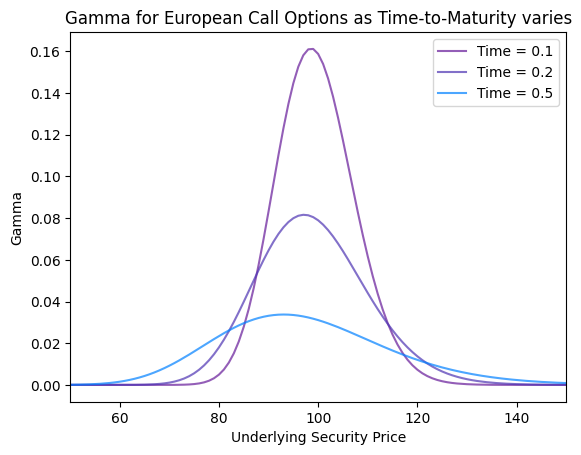

In [44]:
def plot_gamma():

    params_dict = {
        'S': np.arange(10, 200, 1),
        'X': 100,
        'T': np.array([0.1, 0.2, 0.5]),
        'option_type': 'c',
        'r': 0.05,
        'sigma': 0.25,}

    _, ax = plt.subplots()

    for time in params_dict['T']:
        # Copy the params dict but with only the single value under time key
        temp_params_dict=params_dict.copy()
        temp_params_dict['T']=time
        df = pd.DataFrame({'Gamma':gamma(*temp_params_dict.values()),
                        'Spot':params_dict['S']})

        df.plot('Spot', 'Gamma', kind = 'line',
                color = (0.5-time,time,0.5+time), label = f'Time = {time}',
                ax = ax, alpha=0.7, xlim=(50,150))

    ax.set(xlabel = 'Underlying Security Price', ylabel = 'Gamma',
           title = 'Gamma for European Call Options as Time-to-Maturity varies')
    plt.show()

plot_gamma()

In [ ]:
# Thoughts
# Introduce sliders to gamma function
# Simplify code further
# Add MC volatility